In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../scripts')  # This points to the folder containing the .py file

from data_preprocessing import load_data, clean_data

df = load_data('../data/df_cleaned.csv')
df_claim = clean_data(df)  # ✅ This is correct – call the function and store the result

In [3]:
df_claim = df_claim.drop(columns=[ 'TotalPremium','loss ratio', 'TransactionYear',
                                   'VehicleIntroDate', 'TransactionMonth','loss ratio','MainCrestaZone',
                                  'SubCrestaZone','PostalCode' ], errors='ignore')

In [4]:
threshold = df_claim['TotalClaims'].quantile(0.99)
df_filtered = df_claim[df_claim['TotalClaims'] <= threshold]


print(f"Original rows: {df_claim.shape[0]}")
print(f"Filtered rows: {df_filtered.shape[0]}")
print(f"Removed rows: {df_claim.shape[0] - df_filtered.shape[0]}")

Original rows: 2788
Filtered rows: 2760
Removed rows: 28


In [5]:
categorical_cols = df_filtered.select_dtypes(include='object').columns.tolist()
df_encoded = pd.get_dummies(df_filtered, columns=categorical_cols, drop_first=True)

In [6]:

X = df_encoded[['Vehicle_age','SumInsured','Province_Free State',
 'Province_Gauteng',
 'Province_KwaZulu-Natal',
 'Province_Limpopo',
 'Province_Mpumalanga',
 'Province_North West',
 'Province_Northern Cape',
 'Province_Western Cape','VehicleType_Heavy Commercial',
 'VehicleType_Light Commercial',
 'VehicleType_Medium Commercial',
 'VehicleType_Passenger Vehicle',
 'VehicleType_Unknown_Category','MaritalStatus_Not specified',
 'MaritalStatus_Single',
 'MaritalStatus_Unknown_Category','NumberOfDoors']] 
y = df_encoded['TotalClaims']

from train_model import split_data

X_train, X_test, y_train, y_test = split_data(X, y)

# Regression problem: Claim severity 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error,r2_score

models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.2f}, R2={r2:.2f}")

LinearRegression: RMSE=29623.92, R2=0.09
RandomForest: RMSE=28579.27, R2=0.15
XGBoost: RMSE=29897.11, R2=0.07


In [8]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                 # Number of parameter settings sampled
    cv=3,                      # 3-fold cross-validation
    verbose=2,
    n_jobs=-1,                 # Use all processors
    scoring='neg_root_mean_squared_error',  # RMSE as scoring
    random_state=42
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [9]:
best_rf = random_search.best_estimator_

y_pred = best_rf.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Tuned Random Forest RMSE:", round(rmse, 4))
print("Tuned Random Forest R²:", round(r2, 4))
print("Best Parameters:", random_search.best_params_)

Tuned Random Forest RMSE: 25944.6006
Tuned Random Forest R²: 0.2987
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}


c:\Users\techin\Insurance-analytics_week3\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


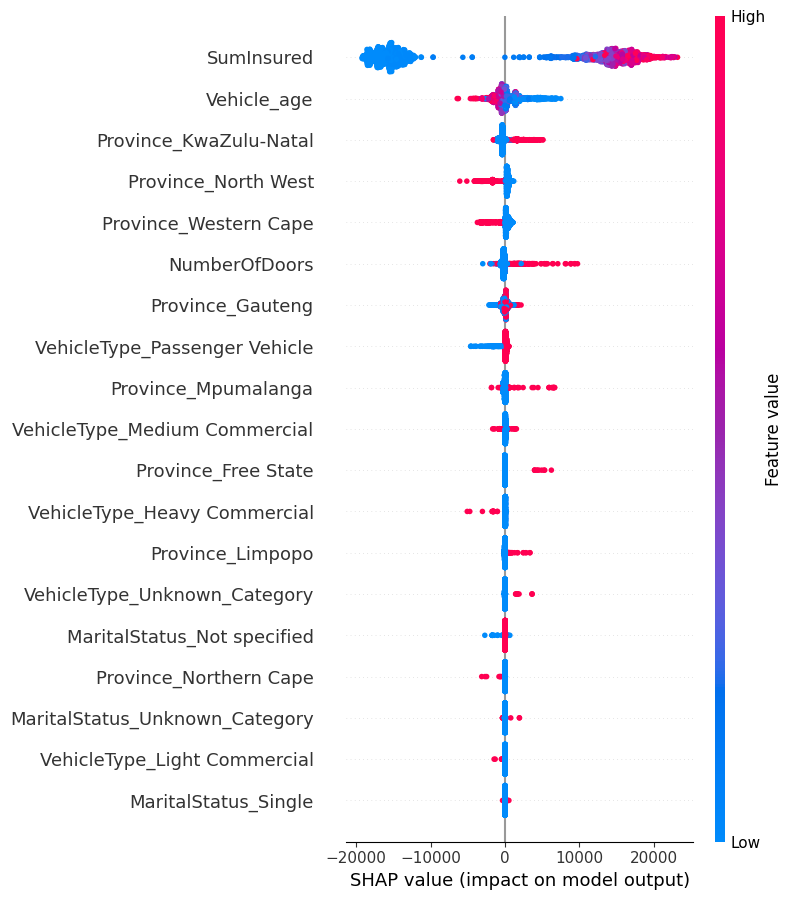

In [10]:
import shap
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [11]:
X_test_reg = X_test

# Classification problem: Claim probability

In [13]:
df = pd.read_csv('../data/df_cleaned.csv')

In [14]:
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

In [15]:
categorical = df.select_dtypes(include='object').columns.tolist()
df_encode = pd.get_dummies(df, columns=categorical, drop_first=True)

In [16]:
X = df_encode[['SumInsured','Province_Free State',
 'Province_Gauteng',
 'Province_KwaZulu-Natal',
 'Province_Limpopo',
 'Province_Mpumalanga',
 'Province_North West',
 'Province_Northern Cape',
 'Province_Western Cape','VehicleType_Heavy Commercial',
 'VehicleType_Light Commercial',
 'VehicleType_Medium Commercial',
 'VehicleType_Passenger Vehicle',
 'VehicleType_Unknown_Category','MaritalStatus_Not specified',
 'MaritalStatus_Single',
 'MaritalStatus_Unknown_Category','NumberOfDoors']] 
y = df_encode['HasClaim']

from train_model import split_data

X_train, X_test, y_train, y_test = split_data(X, y)

In [17]:
from xgboost import XGBClassifier

model = XGBClassifier(
    scale_pos_weight=370,  # imbalance ratio (optional)
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

In [18]:
model.fit(X_train, y_train)

# Now you can use predict_proba
y_probs = model.predict_proba(X_test)[:, 1]

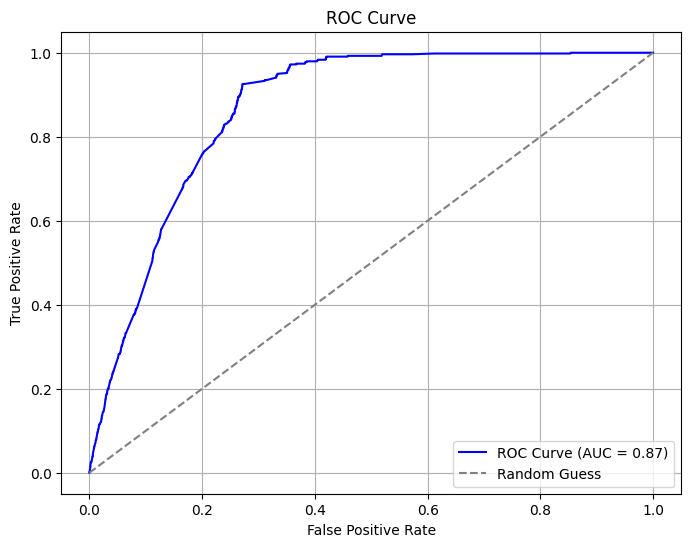

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
X_test_cls = X_test

## Predicted insurance premiums by combining classification model and a regression model

In [24]:
y_probs_series = pd.Series(y_probs, index=X_test_cls.index)
y_pred_series = pd.Series(y_pred, index=X_test_reg.index)

# Step 1: Initialize full severity prediction series (all zeros by default)
severity_all = pd.Series(0.0, index=X_test_cls.index)

# Step 2: Insert severity predictions for only those rows that were in X_test_reg
# Assumes X_test_reg is a subset of X_test_cls (which is typical if severity only predicted for claim-prone cases)
common_indices = X_test_cls.index.intersection(X_test_reg.index)
severity_all.loc[common_indices] = y_pred_series

# Step 3: Calculate predicted premium using expected cost + loadings
expense_loading = 500
profit_margin = 500
predicted_premium = (y_probs_series * severity_all) + expense_loading + profit_margin

# Step 4: Create a full results DataFrame
results = pd.DataFrame({
    'P(Claim)': y_probs_series,
    'PredictedSeverity': severity_all,
    'PredictedPremium': predicted_premium
}).round(2)

# Step 5: Display top 10 by predicted premium
print(results.sort_values(by='PredictedPremium', ascending=False).head(10))

        P(Claim)  PredictedSeverity  PredictedPremium
894656      0.84           49949.28          42982.82
326542      0.86           47691.70          42126.21
220757      0.92           37559.74          35567.11
278798      0.92           37559.74          35567.11
13017       0.87           38974.43          34980.46
553410      0.85           39722.55          34910.23
297514      0.89           37934.46          34826.13
348189      0.90           37594.59          34797.46
69992       0.90           37594.59          34797.46
47231       0.90           37594.59          34797.46
